In [1]:
import pandas as pd
import numpy as np
import os
import tushare as ts
mytoken = '*****' # ***是tushare的api,大家可以自己到tushare上注册获取api,（免费的）
ts.set_token(mytoken)
ts.set_token(mytoken)
save_path = 'stock'
pro = ts.pro_api()

In [2]:
# base_path = 'stock'
# index_df = pd.read_csv(os.path.join(base_path,  'OldData', '000001.SH' + '_NormalData.csv'))
startdate=20040101
enddate=20200101
index_df = pro.index_daily(ts_code='000001.SH',
                     start_date=startdate,
                     end_date=enddate,
                     fields='ts_code, trade_date, open, high, low, close, pre_close, change, pct_chg, '
                            'vol, amount')
index_df = index_df.sort_values('trade_date', ascending=True).reset_index(drop=True)

-------------- 1 -------------

5 天均线上        + 1  层仓

5 天均线下        - 1  层仓

-------------- 2 -------------
10天均线上        + 1.5层仓


偏离3%以内        - 0.5层仓

偏离3%-6%以内      - 1层仓

偏离6%以上        - 1.5层仓

-------------- 3 -------------

21天均线上        + 1.5层仓

偏离3%以内        - 0.5层仓

偏离3%-6%以内      - 1  层仓

偏离6%以上        - 1.5层仓


-------------- 4 -------------

30天均线上        + 1  层仓

偏离5%以内        -0.5 层仓

偏离5%以上        - 1  层仓


-------------- 5 -------------

5 天均线趋势向上    + 1  层仓

趋势走平或向下     - 1  层仓


-------------- 6 -------------

10天均线趋势向上    + 1.5层仓

趋势走平         - 1  层仓

趋势向下         - 1.5层仓


-------------- 7 -------------

21天均线趋势向上    + 1.5层仓

趋势走平         - 1  层仓

趋势向下         - 1.5层仓

-------------- 8 -------------

30天均线趋势向上    + 1  层仓

趋势走平         - 0.5层仓

趋势向下         - 1  层仓

In [3]:
index_df = index_df.sort_values('trade_date', ascending=True).reset_index(drop=True)

In [4]:
# 计算均线
for day in [5, 10, 21, 30]:
    index_df['ma'+str(day)] = index_df.pre_close.rolling(day).mean()

# 计算趋势

In [5]:
col = ['ma5', 'ma10', 'ma21', 'ma30']
tmp_df2 = index_df[col].shift(1)
tmp_df3 = index_df[col].shift(2)
for tmp_col in col:
    index_df[tmp_col + '_trend'] = 0
    # tmp_df[tmp_col + '_shift_1'] = tmp_df2[tmp_col]
    # tmp_df[tmp_col _ 'shift_2'] = tmp_df3[tmp_col]
    index_df['rate1'] = (tmp_df2[tmp_col] - tmp_df3[tmp_col]) / (tmp_df3[tmp_col] + 0.00001)
    index_df['rate2'] = (index_df[tmp_col] - tmp_df2[tmp_col]) / (tmp_df2[tmp_col] + 0.00001)
    idx = (index_df['rate1'] > 0.005) & (index_df['rate2'] > 0.005)
    index_df.loc[idx, tmp_col + '_trend'] = 1 # 趋势向上

    idx = (index_df['rate1'] < -0.005) & (index_df['rate2'] < -0.005)
    index_df.loc[idx, tmp_col + '_trend'] = 2 # 趋势向下

In [19]:
index_df.head()

,ts_code,trade_date,close,open,high,low,pre_close,change,pct_chg,vol,...,ma5,ma10,ma21,ma30,ma5_trend,rate1,rate2,ma10_trend,ma21_trend,ma30_trend
0,000001.SH,20040226,1654.898,1642.409,1655.295,1628.840,1647.381,7.517,0.4563,23111684.0,...,1690.0198,1689.0167,1672.066524,1648.172867,0,0.003771,0.002640,0,0,0
1,000001.SH,20040227,1675.067,1657.262,1675.323,1657.039,1654.898,20.169,1.2187,19708363.0,...,1677.5964,1688.1233,1674.660476,1651.057700,2,0.002640,0.001750,0,0,0
2,000001.SH,20040301,1689.760,1676.222,1690.070,1661.339,1675.067,14.693,0.8772,19990178.0,...,1668.2594,1689.7761,1676.861905,1654.409167,2,0.001750,0.002030,0,0,0
3,000001.SH,20040302,1687.278,1692.616,1694.815,1677.979,1689.760,-2.482,-0.1469,20507503.0,...,1669.8806,1689.0694,1681.577667,1657.827700,0,0.002030,0.002066,0,0,0
4,000001.SH,20040303,1661.812,1686.964,1688.935,1654.564,1687.278,-25.466,-1.5093,19239974.0,...,1670.8768,1687.4198,1684.596619,1660.399433,0,0.002066,0.001551,0,0,0


In [7]:
index_df = index_df.loc[31:].reset_index(drop=True)
index_df_copy = index_df.copy()

In [8]:
def compute_score(index_df, i):
    score = 0
    tmp_rate = (index_df['close'][i]-index_df['ma5'][i])
    if tmp_rate>=0:
        score += 1
        
    tmp_rate = (index_df['close'][i]-index_df['ma10'][i])
    if tmp_rate>=0:
        score += 1.5
    elif tmp_rate>-0.03:
        score += 1
    elif tmp_rate>-0.06:
        score += 0.5
    
    tmp_rate = (index_df['close'][i]-index_df['ma21'][i])
    if tmp_rate>=0:
        score += 1.5
    elif tmp_rate>-0.03:
        score += 1
    elif tmp_rate>-0.06:
        score += 0.5

    tmp_rate = (index_df['close'][i]-index_df['ma30'][i])
    if tmp_rate>=0:
        score += 1
    elif tmp_rate>-0.5:
        score += 0.5
    
    if index_df['ma5_trend'][i] == 1:
        score += 1
    
    if index_df['ma10_trend'][i] == 1:
        score += 1.5
    elif index_df['ma10_trend'][i] == 0:
        score += 0.5

    if index_df['ma21_trend'][i] == 1:
        score += 1.5
    elif index_df['ma21_trend'][i] == 0:
        score += 0.5
        
    if index_df['ma21_trend'][i] == 1:
        score += 1
    elif index_df['ma21_trend'][i] == 0:
        score += 0.5
        
    return score
    

In [9]:
def print_info(hold_money, hold_market_value, index_df, i, kind, change_amount):
    trade_date = index_df['trade_date'][i]
    change_amount = round(change_amount,2)
    rate = (index_df['close'][i] - index_df['pre_close'][i]) / index_df['pre_close'][i]
    rate = round(rate, 2)
    info = str(trade_date)
    if rate > 0:
        info += ', 上涨' + str(rate)
    else:
        info += ', 下跌' + str(rate)
        
    if kind == 1:
        info += ', 加仓' + str(change_amount) 
    
    elif kind == 2:
        info += ', 减仓' + str(change_amount) 
    
    info += ',持有现金：'+str(round(hold_money,2))+',持有市值：'+\
    str(round(hold_market_value,2))+',总市值：'+str(round(hold_money+hold_market_value,2))
    print(info)

In [34]:
# 设置起始时间
# 2004年1月1日开始
# index_df = index_df_copy.loc[:].reset_index(drop=True)
# index_df.head()

# 2007年11月1日开始
index_df = index_df_copy.loc[895:].reset_index(drop=True)
index_df.head()

,ts_code,trade_date,close,open,high,low,pre_close,change,pct_chg,vol,...,ma5,ma10,ma21,ma30,ma5_trend,rate1,rate2,ma10_trend,ma21_trend,ma30_trend
0,000001.SH,20071101,5914.285,5978.939,6005.131,5912.502,5954.765,-40.480,-0.6798,64885103.0,...,5750.3960,5767.9137,5768.304286,5659.922033,0,0.004656,0.004628,0,0,0
1,000001.SH,20071102,5777.809,5812.465,5860.594,5740.403,5914.285,-136.476,-2.3076,59541596.0,...,5820.7742,5776.8140,5795.721667,5681.278467,0,0.004628,0.003773,0,0,0
2,000001.SH,20071105,5634.452,5748.176,5787.228,5603.470,5777.809,-143.357,-2.4812,64132597.0,...,5858.4098,5772.7902,5813.264810,5696.799367,1,0.003773,0.002732,0,0,0
3,000001.SH,20071106,5536.569,5593.347,5649.752,5510.161,5634.452,-97.883,-1.7372,45068039.0,...,5835.7008,5769.5022,5817.176762,5703.901367,0,0.002732,0.001247,0,0,0
4,000001.SH,20071107,5601.783,5565.648,5610.953,5469.761,5536.569,65.214,1.1779,42730328.0,...,5763.5760,5745.8204,5809.739333,5707.613400,0,0.001247,0.000651,0,0,0


In [35]:


score_list = []
hold_mount = 0
money_init = 100000
hold_money = money_init
hold_market_value = 0
hold_market_value_list = []
hold_money_list = []
all_value_list = []
change_amount = 0
for i in range(len(index_df)):
    score = compute_score(index_df, i) / 10
    if i == 0:
        buy_money = int(money_init * score)
        hold_market_value = buy_money
        hold_money = hold_money - buy_money
        print(str(index_df['trade_date'][i])+'买入：'+str(str(buy_money)))
    else:
        hold_market_value = hold_market_value * index_df['close'][i]/index_df['pre_close'][i]
        if score_list[-1] == score:
            kind = 0
            
        elif score_list[-1] < score: #加仓
            if score_list[-1] == 0:
                add_mount = score
            else:
                add_mount = score - score_list[-1]
            
            buy_money = int(hold_money/(1-score_list[-1])* (add_mount))
            hold_market_value += buy_money
            hold_money -= buy_money
            kind = 1
            change_amount = add_mount
            
        else: #减仓
            reduce_mount =  score_list[-1] - score
            sell_money = int(hold_market_value/score_list[-1] * (reduce_mount))
            hold_market_value -= sell_money
            hold_money += sell_money
            change_amount = sell_money
            kind = 2
            
        print_info(hold_money, hold_market_value, index_df, i, kind, change_amount) 
        
    score_list.append(score)
    hold_market_value_list.append(hold_market_value)
    hold_money_list.append(hold_money)
    all_value_list.append(hold_money+hold_market_value)

20071101买入：65000
20071102, 下跌-0.02, 减仓24423,持有现金：59423,持有市值：39077.08,总市值：98500.08
20071105, 下跌-0.02, 减仓14290,持有现金：73713,持有市值：23817.52,总市值：97530.52
20071106, 下跌-0.02, 减仓9361,持有现金：83074,持有市值：14042.75,总市值：97116.75
20071107, 上涨0.01,持有现金：83074,持有市值：14208.16,总市值：97282.16
20071108, 下跌-0.05,持有现金：83074,持有市值：13518.88,总市值：96592.88
20071109, 下跌-0.0,持有现金：83074,持有市值：13482.14,总市值：96556.14
20071112, 下跌-0.02,持有现金：83074,持有市值：13157.98,总市值：96231.98
20071113, 下跌-0.01,持有现金：83074,持有市值：13082.86,总市值：96156.86
20071114, 上涨0.05, 减仓4576,持有现金：87650,持有市值：9152.56,总市值：96802.56
20071115, 下跌-0.01,持有现金：87650,持有市值：9072.36,总市值：96722.36
20071116, 下跌-0.01,持有现金：87650,持有市值：8989.52,总市值：96639.52
20071119, 下跌-0.01,持有现金：87650,持有市值：8910.96,总市值：96560.96
20071120, 下跌0.0,持有现金：87650,持有市值：8951.35,总市值：96601.35
20071121, 下跌-0.02, 加仓0.05,持有现金：82781,持有市值：13685.96,总市值：96466.96
20071122, 下跌-0.04,持有现金：82781,持有市值：13082.1,总市值：95863.1
20071123, 上涨0.01, 减仓4402,持有现金：87183,持有市值：8806.01,总市值：95989.01
20071126, 下跌-0.01,持有现金：87183,持有市值：8677.77,总市值：95860

20091027, 下跌-0.03, 减仓26066,持有现金：52236,持有市值：52132.49,总市值：104368.49
20091028, 下跌0.0, 减仓10460,持有现金：62696,持有市值：41842.79,总市值：104538.79
20091029, 下跌-0.02, 减仓5108,持有现金：67804,持有市值：35756.63,总市值：103560.63
20091030, 上涨0.01, 加仓0.05,持有现金：62589,持有市值：41398.98,总市值：103987.98
20091102, 上涨0.03, 加仓0.25,持有现金：36511,持有市值：68593.55,总市值：105104.55
20091103, 上涨0.01,持有现金：36511,持有市值：69431.35,总市值：105942.35
20091104, 下跌0.0,持有现金：36511,持有市值：69750.39,总市值：106261.39
20091105, 上涨0.01, 加仓0.1,持有现金：26080,持有市值：80772.56,总市值：106852.56
20091106, 下跌0.0, 加仓0.15,持有现金：10432,持有市值：96650.56,总市值：107082.56
20091109, 下跌0.0,持有现金：10432,持有市值：97003.31,总市值：107435.31
20091110, 下跌0.0, 减仓16182,持有现金：26614,持有市值：80913.71,总市值：107527.71
20091111, 下跌-0.0, 减仓10776,持有现金：37390,持有市值：70050.71,总市值：107440.71
20091112, 下跌-0.0,持有现金：37390,持有市值：70001.13,总市值：107391.13
20091113, 下跌0.0,持有现金：37390,持有市值：70325.49,总市值：107715.49
20091116, 上涨0.03, 加仓0.1,持有现金：26708,持有市值：82935.72,总市值：109643.72
20091117, 下跌0.0,持有现金：26708,持有市值：83134.28,总市值：109842.28
20091118, 上涨0.01, 加仓0.1,持有现

20110519, 下跌-0.0, 减仓15528,持有现金：78075,持有市值：25880.39,总市值：103955.39
20110520, 下跌-0.0, 减仓10348,持有现金：88423,持有市值：15522.3,总市值：103945.3
20110523, 下跌-0.03,持有现金：88423,持有市值：15066.75,总市值：103489.75
20110524, 下跌-0.0,持有现金：88423,持有市值：15025.96,总市值：103448.96
20110525, 下跌-0.01,持有现金：88423,持有市值：14888.49,总市值：103311.49
20110526, 下跌-0.0,持有现金：88423,持有市值：14860.17,总市值：103283.17
20110527, 下跌-0.01,持有现金：88423,持有市值：14715.84,总市值：103138.84
20110530, 下跌-0.0,持有现金：88423,持有市值：14696.36,总市值：103119.36
20110531, 上涨0.01, 加仓0.05,持有现金：83222,持有市值：20098.89,总市值：103320.89
20110601, 下跌0.0, 加仓0.05,持有现金：78021,持有市值：25300.62,总市值：103321.62
20110602, 下跌-0.01, 减仓9978,持有现金：87999,持有市值：14968.59,总市值：102967.59
20110603, 上涨0.01, 加仓0.1,持有现金：77647,持有市值：25446.96,总市值：103093.96
20110607, 上涨0.01, 加仓0.15,持有现金：62118,持有市值：41127.82,总市值：103245.82
20110608, 下跌0.0,持有现金：62118,持有市值：41217.56,总市值：103335.56
20110609, 下跌-0.02, 减仓25321,持有现金：87439,持有市值：15193.04,总市值：102632.04
20110610, 下跌0.0,持有现金：87439,持有市值：15203.15,总市值：102642.15
20110613, 下跌-0.0,持有现金：87439,持有市值：15176

20120816, 下跌-0.0,持有现金：79745,持有市值：13904.29,总市值：93649.29
20120817, 下跌0.0,持有现金：79745,持有市值：13922.02,总市值：93667.02
20120820, 下跌-0.0,持有现金：79745,持有市值：13869.8,总市值：93614.8
20120821, 上涨0.01,持有现金：79745,持有市值：13944.25,总市值：93689.25
20120822, 下跌-0.0,持有现金：79745,持有市值：13874.76,总市值：93619.76
20120823, 下跌0.0, 加仓0.1,持有现金：70364,持有市值：23291.05,总市值：93655.05
20120824, 下跌-0.01, 减仓9223,持有现金：79587,持有市值：13836.93,总市值：93423.93
20120827, 下跌-0.02,持有现金：79587,持有市值：13596.21,总市值：93183.21
20120828, 上涨0.01,持有现金：79587,持有市值：13711.6,总市值：93298.6
20120829, 下跌-0.01,持有现金：79587,持有市值：13579.86,总市值：93166.86
20120830, 下跌-0.0,持有现金：79587,持有市值：13575.56,总市值：93162.56
20120831, 下跌-0.0,持有现金：79587,持有市值：13542.07,总市值：93129.07
20120903, 上涨0.01, 加仓0.1,持有现金：70224,持有市值：22981.96,总市值：93205.96
20120904, 下跌-0.01, 减仓9123,持有现金：79347,持有市值：13685.99,总市值：93032.99
20120905, 下跌-0.0,持有现金：79347,持有市值：13646.02,总市值：92993.02
20120906, 上涨0.01, 加仓0.1,持有现金：70013,持有市值：23075.36,总市值：93088.36
20120907, 上涨0.04, 加仓0.4,持有现金：32673,持有市值：61268.29,总市值：93941.29
20120910, 下跌0.0,持有现金：32

20140217, 上涨0.01,持有现金：23717,持有市值：73807.8,总市值：97524.8
20140218, 下跌-0.01, 减仓9765,持有现金：33482,持有市值：63477.72,总市值：96959.72
20140219, 上涨0.01,持有现金：33482,持有市值：64181.31,总市值：97663.31
20140220, 下跌-0.0,持有现金：33482,持有市值：64068.32,总市值：97550.32
20140221, 下跌-0.01, 减仓9741,持有现金：43223,持有市值：53575.76,总市值：96798.76
20140224, 下跌-0.02, 减仓14355,持有现金：57578,持有市值：38282.75,总市值：95860.75
20140225, 下跌-0.02, 减仓23437,持有现金：81015,持有市值：14062.89,总市值：95077.89
20140226, 下跌0.0,持有现金：81015,持有市值：14111.52,总市值：95126.52
20140227, 下跌0.0,持有现金：81015,持有市值：14153.69,总市值：95168.69
20140228, 下跌0.0,持有现金：81015,持有市值：14215.55,总市值：95230.55
20140303, 上涨0.01, 加仓0.2,持有现金：61953,持有市值：33408.44,总市值：95361.44
20140304, 下跌-0.0,持有现金：61953,持有市值：33347.88,总市值：95300.88
20140305, 下跌-0.01, 减仓18886,持有现金：80839,持有市值：14165.84,总市值：95004.84
20140306, 下跌0.0,持有现金：80839,持有市值：14210.65,总市值：95049.65
20140307, 下跌-0.0,持有现金：80839,持有市值：14199.12,总市值：95038.12
20140310, 下跌-0.03,持有现金：80839,持有市值：13793.12,总市值：94632.12
20140311, 下跌0.0,持有现金：80839,持有市值：13807.55,总市值：94646.55
20140312, 下跌-0.0

20150924, 上涨0.01, 加仓0.4,持有现金：76719,持有市值：62764.55,总市值：139483.55
20150925, 下跌-0.02, 减仓41172,持有现金：117891,持有市值：20587.18,总市值：138478.18
20150928, 下跌0.0,持有现金：117891,持有市值：20643.17,总市值：138534.17
20150929, 下跌-0.02,持有现金：117891,持有市值：20226.28,总市值：138117.28
20150930, 下跌0.0,持有现金：117891,持有市值：20323.78,总市值：138214.78
20151008, 上涨0.03, 加仓0.4,持有现金：62413,持有市值：76404.78,总市值：138817.78
20151009, 上涨0.01, 加仓0.1,持有现金：48544,持有市值：91241.05,总市值：139785.05
20151012, 上涨0.03,持有现金：48544,持有市值：94236.72,总市值：142780.72
20151013, 下跌0.0, 加仓0.1,持有现金：34675,持有市值：108265.32,总市值：142940.32
20151014, 下跌-0.01,持有现金：34675,持有市值：107253.13,总市值：141928.13
20151015, 上涨0.02,持有现金：34675,持有市值：109739.53,总市值：144414.53
20151016, 上涨0.02,持有现金：34675,持有市值：111491.07,总市值：146166.07
20151019, 下跌-0.0, 加仓0.1,持有现金：20806,持有市值：125207.16,总市值：146013.16
20151020, 上涨0.01,持有现金：20806,持有市值：126635.32,总市值：147441.32
20151021, 下跌-0.03, 减仓14443,持有现金：35249,持有市值：108323.23,总市值：143572.23
20151022, 上涨0.01, 减仓14652,持有现金：49901,持有市值：95239.07,总市值：145140.07
20151023, 上涨0.01, 加仓0.1,持有现金：3

20170419, 下跌-0.01,持有现金：118813,持有市值：20413.82,总市值：139226.82
20170420, 下跌0.0,持有现金：118813,持有市值：20422.92,总市值：139235.92
20170421, 下跌0.0,持有现金：118813,持有市值：20429.68,总市值：139242.68
20170424, 下跌-0.01,持有现金：118813,持有市值：20148.84,总市值：138961.84
20170425, 下跌0.0,持有现金：118813,持有市值：20181.27,总市值：138994.27
20170426, 下跌0.0,持有现金：118813,持有市值：20221.7,总市值：139034.7
20170427, 下跌0.0, 加仓0.1,持有现金：104835,持有市值：34272.71,总市值：139107.71
20170428, 下跌0.0,持有现金：104835,持有市值：34299.58,总市值：139134.58
20170502, 下跌-0.0,持有现金：104835,持有市值：34180.56,总市值：139015.56
20170503, 下跌-0.0, 减仓13635,持有现金：118470,持有市值：20454.6,总市值：138924.6
20170504, 下跌-0.0,持有现金：118470,持有市值：20402.56,总市值：138872.56
20170505, 下跌-0.01,持有现金：118470,持有市值：20243.83,总市值：138713.83
20170508, 下跌-0.01,持有现金：118470,持有市值：20084.48,总市值：138554.48
20170509, 下跌0.0,持有现金：118470,持有市值：20096.97,总市值：138566.97
20170510, 下跌-0.01,持有现金：118470,持有市值：19915.99,总市值：138385.99
20170511, 下跌0.0,持有现金：118470,持有市值：19972.84,总市值：138442.84
20170512, 上涨0.01, 加仓0.1,持有现金：104533,持有市值：34053.45,总市值：138586.45
20170515, 下跌0.0

20181228, 下跌0.0,持有现金：106951,持有市值：18044.53,总市值：124995.53
20190102, 下跌-0.01,持有现金：106951,持有市值：17837.56,总市值：124788.56
20190103, 下跌-0.0,持有现金：106951,持有市值：17830.85,总市值：124781.85
20190104, 上涨0.02, 加仓0.25,持有现金：75495,持有市值：49652.28,总市值：125147.28
20190107, 上涨0.01,持有现金：75495,持有市值：50012.01,总市值：125507.01
20190108, 下跌-0.0,持有现金：75495,持有市值：49881.18,总市值：125376.18
20190109, 上涨0.01, 加仓0.15,持有现金：56622,持有市值：69107.25,总市值：125729.25
20190110, 下跌-0.0, 减仓18778,持有现金：75400,持有市值：50078.11,总市值：125478.11
20190111, 上涨0.01, 加仓0.25,持有现金：43984,持有市值：81864.15,总市值：125848.15
20190114, 下跌-0.01, 减仓31263,持有现金：75247,持有市值：50022.04,总市值：125269.04
20190115, 上涨0.01, 加仓0.25,持有现金：43895,持有市值：82056.18,总市值：125951.18
20190116, 下跌0.0,持有现金：43895,持有市值：82058.65,总市值：125953.65
20190117, 下跌-0.0,持有现金：43895,持有市值：81714.34,总市值：125609.34
20190118, 上涨0.01,持有现金：43895,持有市值：82875.38,总市值：126770.38
20190121, 上涨0.01,持有现金：43895,持有市值：83338.4,总市值：127233.4
20190122, 下跌-0.01, 减仓12669,持有现金：56564,持有市值：69685.97,总市值：126249.97
20190123, 下跌0.0,持有现金：56564,持有市值：69721.09,总市

In [36]:
rate1 = round(index_df['close'][len(index_df)-1] / index_df['close'][0] - 1,2)
rate2 = round(all_value_list[-1] / money_init - 1, 2)

print('指数涨幅:'+str(rate1)+'， 账户涨幅：'+str(rate2))

指数涨幅:-0.48， 账户涨幅：0.41


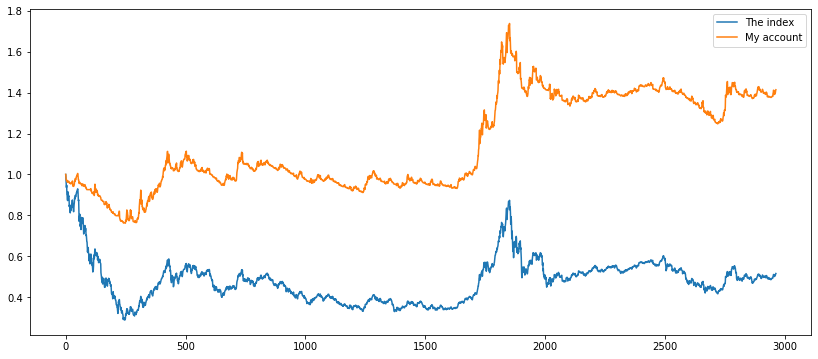

In [37]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 6))
index = index_df['close'] / index_df['close'][0]
my_account = np.array(all_value_list) / money_init
plt.plot(index, label='The index')
plt.plot(my_account, label='My account')
plt.legend()
plt.show()

# plt.figure(figsize=(16, 4))
# plt.plot(score_list)
# plt.legend()
# plt.show()

In [17]:
1.087 ** 16

3.7990298451359554

In [39]:
1.03 ** 12

1.4257608868461793